### Preamble

In [52]:
%matplotlib inline
import Euclid
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from astropy.table import Table, join, vstack
from astropy import units as u
from astropy.units import photometric
from astropy.coordinates import SkyCoord
from glob import glob
import healpy

In [65]:
plt.rcParams['figure.figsize'] = (20, 10)

In [3]:
%elogin
%erun Phosphoros
%erun PHZ_NNPZ

In [4]:
from nnpz.reference_sample.ReferenceSample import ReferenceSample
from PhzCLI.PlotSpecZComparison import SpeczPhotozPlot, displayHistogram, compute_stats, boxPlot

# Input catalogs

Read the documentation of the [PhzEASTools](https://gitlab.euclid-sgs.uk/PF-PHZ/PHZ_ToolBox/-/tree/develop/PhzEASTools) to
see how to obtain the MER input catalog and PHZ output catalog.

In [89]:
# Where PhzEASTools stores the data
ppos_dir = os.path.expanduser('~/Work/Data/SC7/Pipelines/')
# PPO to validate
ppo_id = 'PS_DEV_PHZProduction_20200310-VALIDATION-nmorisse-PLAN-0001-2020-04-24-21-48-02-12'

## PHZ and MER

In [104]:
phz_column = 'PHZ_MODE'

In [90]:
ppo_dir = os.path.join(ppos_dir, ppo_id)
phz_catalog_path = glob(os.path.join(ppo_dir, 'EUC_PHZ_PHZCAT__*.fits'))[0]
mer_catalog_path = glob(os.path.join(ppo_dir, 'EUC_MER_FINAL-CAT_*.fits'))[0]

In [91]:
phz_catalog = Table.read(phz_catalog_path, hdu=1)
mer_catalog = Table.read(mer_catalog_path, hdu=1)

In [92]:
phz_mer_catalog = join(phz_catalog, mer_catalog, 'OBJECT_ID')

## True Universe

In [93]:
tu_columns = ['SOURCE_ID', 'RA_MAG', 'DEC_MAG', 'Z_OBS']

You can obtain the TU tiles from [PIC's WebDAV server](https://shared.euclid.pic.es/SPV/GALAXIES/). The following code helps you to know which tiles
are needed.

In [94]:
mer_tu_tile = healpy.pixelfunc.ang2pix(32, mer_catalog['RIGHT_ASCENSION'], mer_catalog['DECLINATION'], lonlat=True, nest=True)
tu_tiles, tu_tiles_count = np.unique(mer_tu_tile, return_counts=True)
for tile, count in zip(tu_tiles, tu_tiles_count):
    print(f'Need TU Tile {tile} for {count} objects')

Need TU Tile 4208 for 68557 objects


/home/aalvarez/miniconda3/envs/phz/lib/python3.7/site-packages/healpy/pixelfunc.py:479: RuntimeWarning: invalid value encountered in _ang2pix_nest
  return pixlib._ang2pix_nest(nside, theta, phi)


In [95]:
tu_dir = os.path.expanduser('~/Work/Data/SC7/TU/')
tu_catalogs = []
for tile in tu_tiles:
    tu_catalog_path = glob(os.path.join(tu_dir, f'EUC-GALCAT-*_HPIX_5_NEST_{tile}.fits'))[0]
    tu_catalogs.append(Table.read(tu_catalog_path)[tu_columns])
tu_catalog = vstack(tu_catalogs)
print('Read', len(tu_catalog), 'objects from the TU')

Read 1873604 objects from the TU


## Join with TU Z_OBS

In [96]:
phz_coords = SkyCoord(phz_mer_catalog['RIGHT_ASCENSION'], phz_mer_catalog['DECLINATION'])
tu_coors = SkyCoord(tu_catalog['RA_MAG'] * u.deg, tu_catalog['DEC_MAG'] * u.deg)

In [97]:
tu_idx, tu_distances, _ = phz_coords.match_to_catalog_sky(tu_coors)

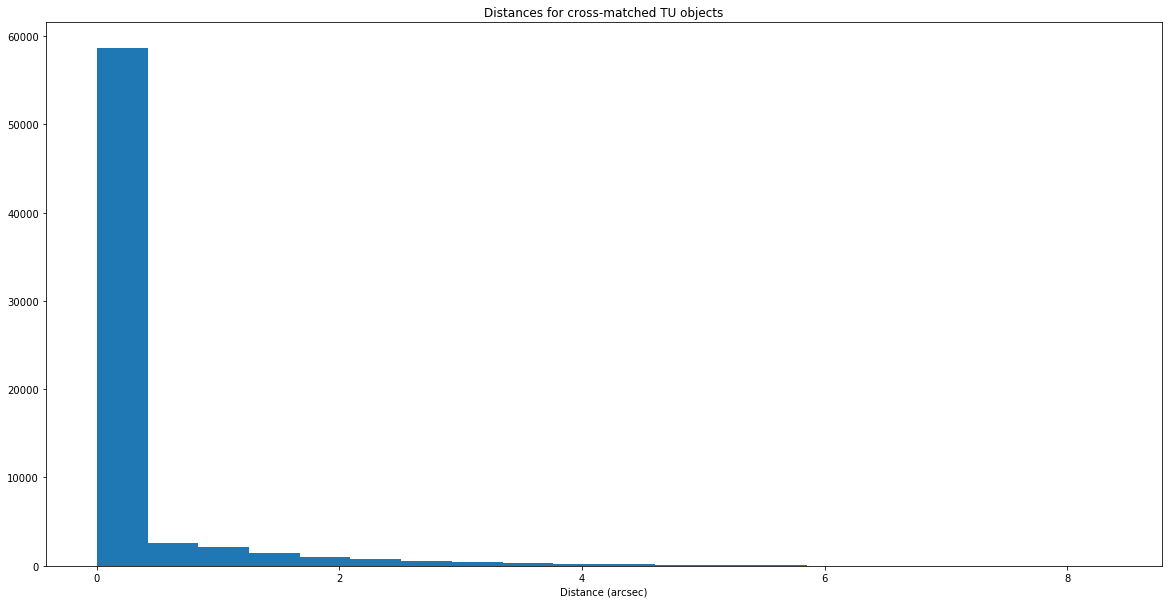

In [98]:
plt.figure()
plt.title('Distances for cross-matched TU objects')
plt.hist(tu_distances.arcsec, bins=20)
plt.xlabel('Distance (arcsec)')
_ = plt.show()

In [99]:
# Restrict to those close enough
match_filter = tu_distances <= 1. * u.arcsec
tu_matched = tu_catalog[tu_idx[match_filter]]
phz_matched = phz_mer_catalog[match_filter]
assert len(tu_matched) == len(phz_matched)

In [100]:
print(len(phz_matched))

62200


In [101]:
# Copy Z_OBS
phz_matched['Z_OBS'] = tu_matched['Z_OBS']

In [106]:
data, mean, median, sigma, mad, outliersPercent,sigmaNoOutliers, meanNoOutliers = compute_stats(phz_matched['Z_OBS'], phz_matched[phz_column])

--> Mean                :  0.063700154
--> Median              :  -0.013895872
--> Sigma               :  0.40676197
--> Mad                 :  0.17295268
--> Outliers            :  55.11414790996785 %
--> Sigma (no outliers) :  0.042579755


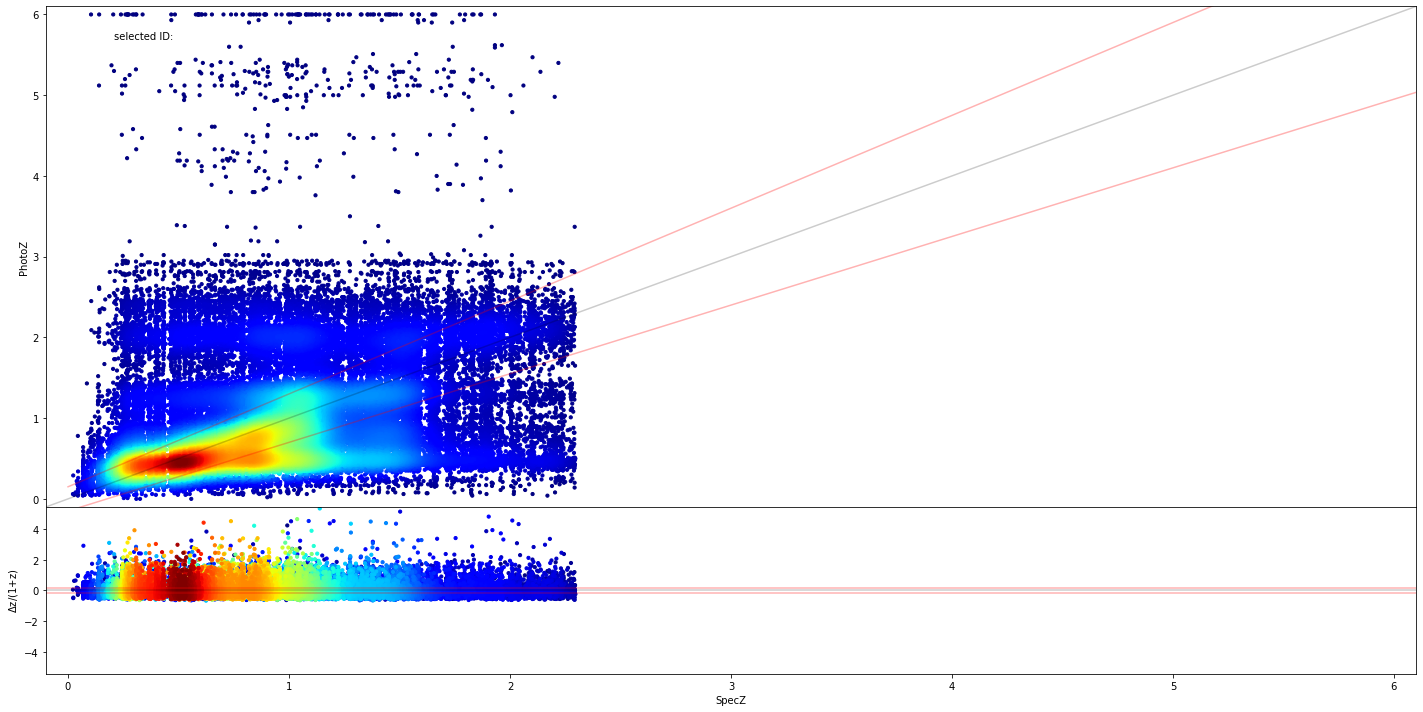

In [107]:
SpeczPhotozPlot(phz_matched['OBJECT_ID'], phz_matched['Z_OBS'], phz_matched[phz_column], data)